Quellen:  
Analyse der Blockchain https://www.chainalysis.com/  
bitiodine, Bitcoin parser mit Clustering: https://github.com/mikispag/bitiodine (nicht mehr aktiv)  
Multi Signature: https://en.bitcoin.it/wiki/Multisignature  
CCC 28c3: Bitcoin - An Analysis https://www.youtube.com/watch?v=hlWyTqL1hFA  
Bitcoin "Invoice" https://en.bitcoin.it/wiki/Address_reuse  
Enhance Bitcoin Anonimity https://www.bitcoinnotbombs.com/innovations-that-enhance-bitcoin-anonymity/  
Beispiel für change: https://bitcoin.stackexchange.com/questions/9007/why-are-there-two-transaction-outputs-when-sending-to-one-address  
unspent transactions: https://coinsutra.com/unspent-transaction-outputs-utxos/  

In [5]:
import pandas as pd
import requests
from graphviz import Digraph
from Adressen import Adressen
import json
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('reports02022021.csv')
df = df.drop(columns=['description', 'abuse_type_other'])
df.head()

,id,address,abuse_type_id,abuser,from_country,from_country_code,created_at
0,209319,1KNky3De36qfDAimJaTXru6LoFUftg7kpC,5,TFHCYY81@ARORA.COM.IN,Uruguay,UY,2021-01-01T00:20:33.000000Z
1,209320,1Nd3JST1daeyzmPovkRoemjysA6JfXjVRg,4,steve.holmes@capellabioscience.com,United States,US,2021-01-01T00:53:38.000000Z
2,209321,1HqsQFJebHVyEgEsjXGcGVgebaXbayTU8P,4,administration@lovesexbody.com,Russia,RU,2021-01-01T01:06:00.000000Z
3,209322,1J87Q9qS4mwEH2S1pK4MuGm7PrcpSwNGMM,4,mail@bikekingco.com,Russia,RU,2021-01-01T01:07:24.000000Z
4,209323,1BN1tfVf9z5UYmNCwBhpRX31GVdqpNSiU3,1,Ghgf,India,IN,2021-01-01T02:03:37.000000Z


In [3]:
df.address.unique

<bound method Series.unique of 0       1KNky3De36qfDAimJaTXru6LoFUftg7kpC
1       1Nd3JST1daeyzmPovkRoemjysA6JfXjVRg
2       1HqsQFJebHVyEgEsjXGcGVgebaXbayTU8P
3       1J87Q9qS4mwEH2S1pK4MuGm7PrcpSwNGMM
4       1BN1tfVf9z5UYmNCwBhpRX31GVdqpNSiU3
                       ...                
5212    17T8PE5CHFUvkBPM7FVsgZKDDxevzindfL
5213    17LZreCYBa7ikp86xSTrxsvRaAVvEvfvdV
5214    1NqRYEwwvQdMT6cz46EBS2hb47HPJ3f8FF
5215    1D6QyV5oENzt4e8D3iPqsu4RbeQvsHMyc6
5216    1Kri3MbNKgyfN48Qfna9CDDskdDAunZQt6
Name: address, Length: 5217, dtype: object>

In [4]:
df_addr = pd.read_csv('pblv2021/addresses.csv')

In [5]:
df_addr.head()

,wallet,page,address,balance,transactions,last_used_in_block
0,Poloniex.com,1,12cgpFdJViXbwHbhrA3TuW1EGnL25Zqc3P,1824.185042,63500,668636
1,Poloniex.com,1,17A16QmavnUfCW11DAApiJxp7ARnxN5pGX,318.319762,17510,668644
2,Poloniex.com,1,1GjF4VejdJ2n5eS6WPG2aNU7m5ygyqgmDc,4.777640,4225,668594
3,Poloniex.com,1,1NYH8TchsaVv4qv1pZcaHbHYjgTvtkjb8M,4.516187,14204,668643
4,Poloniex.com,1,1LTBCyh9dKhNNZFaByPXfrkeuAD7yr6A4b,3.083592,24359,465505


In [6]:
local_addresses = Adressen()

In [66]:
class Cashflow():
    
    def __init__(self, address):
        self.address = address
        self.other_addresses = []
        self.receivers = {}
        self.cashflow = {}
        self.next_items = []
        
    def download(self, address):
        return self.getAddress(address)
        """
        url = f'https://blockchain.info/rawaddr/{address}'
        r = requests.get(url)
        if r.status_code != 200:
            raise ValueError(f'Status Code: {r.status_code}')
        return r.json()['txs']
        """
    
    def getAddress(self, address):
        print("Wurde aufgerufen")
        return local_addresses.getAddress(address)['txs']
    
    def receiver_is_wallet(self):
        flat_receivers = [item for sublist in self.receivers.values() for item in sublist]
        return any([a in df_addr.address.values for a in flat_receivers])

    
    def plot(self, color='red', dot_p=None):
        if dot_p is None:
            dot = Digraph()
        else:
            dot = dot_p
        dot.node(self.address, self.address[:3] + "..." + self.address[-3:], color=color)
        
        keys = [key for key in self.cashflow.keys()]
        if len(keys) > 3:
            keys = [keys[0], len(keys)-2, keys[-1]]
        
        self.__create_graph__(dot, keys)
        
        for cash in self.next_items:
            cash.plot(None, dot)            
        return dot
    
    
    def __create_graph__(self, dot, keys):
        for key in keys:
            if type(key) is int:
                name = self.address + str(key) 
                dot.node(name, "+ " + str(key)) 
                dot.edge(self.address, name)
            else:
                val = round(sum(self.cashflow[key]), 3)
                dot.node(key, key[:3] + "..." + key[-3:]) 
                dot.edge(self.address, key, str(val))
        
    
    def __cmp__(self, other):
        return self.address.__cmp__(other.address)
        
        
    def analyse(self, steps):
        return self.__analyse_cashflow__(0, steps)
        
    
    def __analyse_cashflow__(self, step, last_step):
        if step == last_step:
            return self.cashflow
                
        transactions = self.download(self.address)
        
        for tx in range(len(transactions)):
            input_addrs = []
            for addr in transactions[tx]['inputs']:
                try:
                    input_addrs.append(addr['prev_out']['addr'])
                except:
                    continue
            if self.address in input_addrs:
                self.other_addresses.extend(input_addrs)
                self.other_addresses.remove(self.address)
            
                tx_hash = transactions[tx]['hash']
                self.receivers[tx_hash] = []
                
                for out in range(len(transactions[tx]['out'])):
                    try:
                        a = transactions[tx]['out'][out]['addr']
                        val = round(transactions[tx]['out'][out]['value'] / 100_000_000, 3)
                    except:
                        print(f'Fehler bei {tx} {out}')
                        continue
                    
                    if a in self.cashflow:
                        self.cashflow[a].append(val)
                    else:
                        self.cashflow[a] = [val]
                    
                    self.receivers[tx_hash].append(a)
                    
        keys = [item for item in self.cashflow.keys()]
        if len(keys) > 3:
            keys = [keys[0], keys[-1]]
            
        for i in keys:
            try:
                n = Cashflow(i)
                n.__analyse_cashflow__(step+1, last_step)
                self.next_items.append(n)
            except:
                continue
        return self.cashflow
        

In [49]:
cash = Cashflow('1JMnQAUZdGCV4fuP5xmhLRbrB6TBEnA2Z')

In [67]:
cash = Cashflow('1BN1tfVf9z5UYmNCwBhpRX31GVdqpNSiU3')

In [68]:
b = cash.analyse(2)

Wurde aufgerufen
Wurde aufgerufen
Wurde aufgerufen


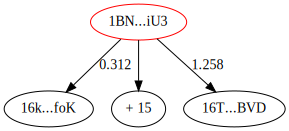

In [69]:
cash.plot()

In [ ]:
cash.next_items[0].plot()

In [ ]:
b

In [ ]:
b[0]

In [ ]:
a = Adressen()

In [ ]:
a.getAddress('1JMnQAUZdGCV4fuP5xmhLRbrB6TBEnA2Z')['txs']

In [ ]:
b[0]

In [ ]:
cash.other_addresses

In [ ]:
cash.receivers

In [ ]:
cash.receiver_is_wallet()